In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from dask.distributed import Client

In [3]:
import cartopy.crs as ccrs

In [12]:
import numpy as np

In [4]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

2023-03-23 14:17:05,697 - distributed.diskutils - INFO - Found stale lock file and directory '/work/2023_larvea_OceanFrontierInstitute/notebooks/dask-worker-space/worker-j_d_59r6', purging
2023-03-23 14:17:05,698 - distributed.diskutils - INFO - Found stale lock file and directory '/work/2023_larvea_OceanFrontierInstitute/notebooks/dask-worker-space/worker-np_sghtq', purging
2023-03-23 14:17:05,699 - distributed.diskutils - INFO - Found stale lock file and directory '/work/2023_larvea_OceanFrontierInstitute/notebooks/dask-worker-space/worker-qr46gy03', purging
2023-03-23 14:17:05,700 - distributed.diskutils - INFO - Found stale lock file and directory '/work/2023_larvea_OceanFrontierInstitute/notebooks/dask-worker-space/worker-_kcqn424', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:8787/status,
Dashboard: http://134.245.3.15:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:36179,Workers: 4
Dashboard: http://134.245.3.15:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.15:38765,Total threads: 2
Dashboard: http://134.245.3.15:46817/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:46525,


In [108]:
data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/"
experiment_name = "VIKING20X.L46-KKG36107B"
data_resolution = '5d'

lat_top = 53
lat_bottom = 41.5
lon_left = -70
lon_right = -45

fname_U = f'1_{experiment_name}_{data_resolution}_201[5-9]*_grid_U.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_201[5-9]*_grid_V.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_201[5-9]*_grid_W.nc'

mask_path = Path('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KKG36107B/nemo/suppl/')
mesh_mask_filename = '1_mesh_mask.nc_notime_depthw'
mesh_mask = mask_path / mesh_mask_filename

In [6]:
data_path = Path(data_path)
files_U = list(sorted((data_path).glob(fname_U)))
files_V = list(sorted((data_path).glob(fname_V)))
files_W = list(sorted((data_path).glob(fname_W)))

In [7]:
ds_u = xr.open_mfdataset(files_U, chunks={"x": 240, "y": 250, "time_counter": 365, "depthu": 5})
ds_v = xr.open_mfdataset(files_V, chunks={"x": 240, "y": 250, "time_counter": 365, "depthv": 5})
ds_w = xr.open_mfdataset(files_W, chunks={"x": 240, "y": 250, "time_counter": 365, "depthw": 5})
ds_mask = xr.open_dataset(mesh_mask)

In [9]:
u = ds_u["vozocrtx"].sel(depthu=slice(0, 10, None)).mean("time_counter")
v = ds_v["vomecrty"].sel(depthv=slice(0, 10, None)).mean("time_counter")
# w = ds_w["vovecrtz"].sel(depthw=slice(0, 10, None)).where(
#     (ds_w.nav_lat >= lat_bottom-5) & (ds_w.nav_lat <= lat_top+5) \
#     & (ds_w.nav_lon >= lon_left-5) & (ds_w.nav_lon <= lon_right+5), drop=True
# );
# mask = ds_mask["umask"].isel(z=0).where(
#     (ds_u.nav_lat >= lat_bottom-5) & (ds_u.nav_lat <= lat_top+5) \
#     & (ds_u.nav_lon >= lon_left-5) & (ds_u.nav_lon <= lon_right+5), drop=True
# )

In [61]:
u = u.rename("u").rename({"depthu": "depth"})
v = v.rename("v").rename({"depthv": "depth"});

In [63]:
vel = xr.combine_by_coords([u, v], compat='override', combine_attrs='drop_conflicts')

In [64]:
vel["vel"] = np.sqrt(vel.u**2 + vel.v**2)

In [66]:
vel = vel.compute()

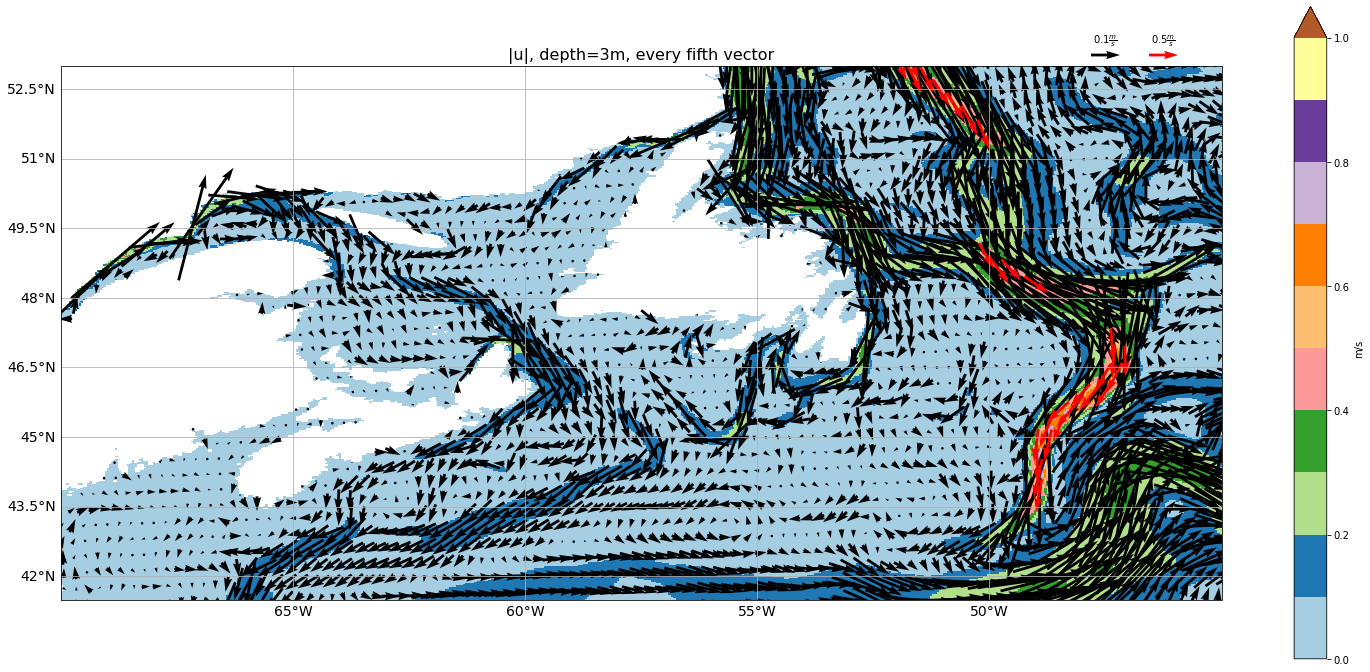

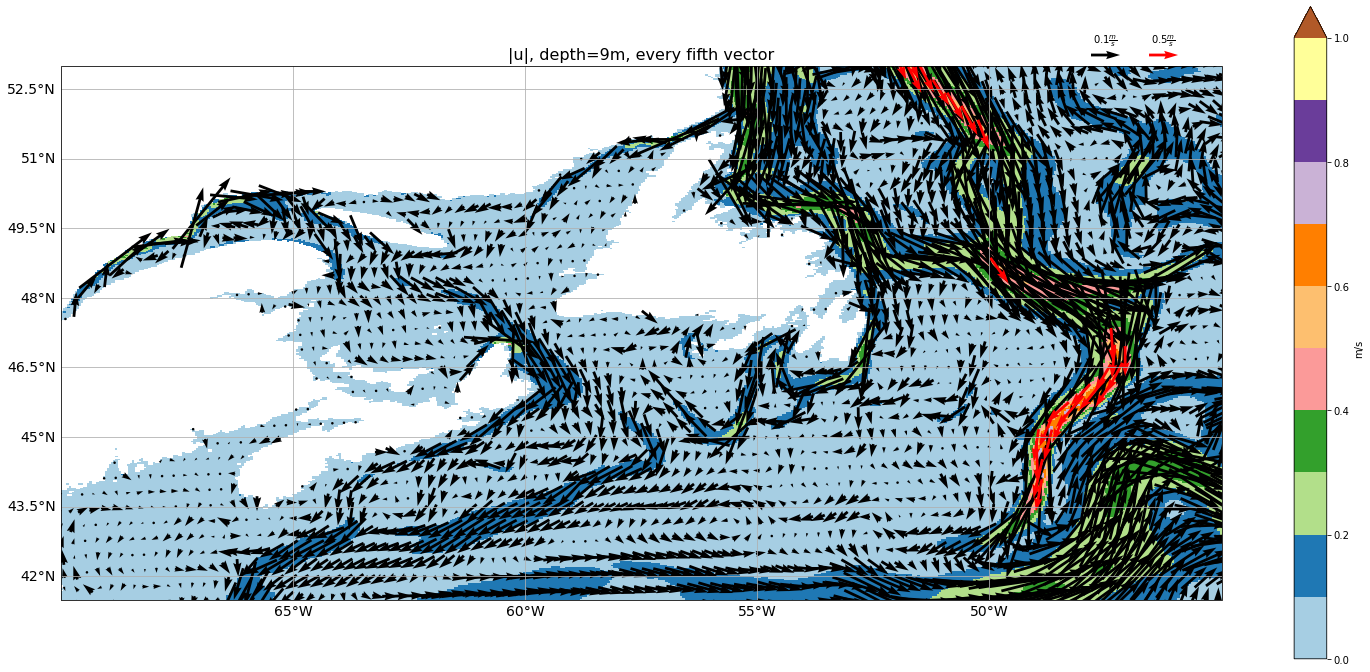

In [269]:
for i, depth in enumerate([3, 9]):
    fig, ax = plt.subplots(
        1, 1,
        sharex=True, sharey=True,
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(26, 12),
    )

    # vel["vel"].isel(depth=i).plot(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", 
    #     cmap=cmocean.cm.speed, cbar_kwargs={"label": "m/s"}
    # )
    # q = vel.isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 5)).plot.quiver(
    #     ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale = 50, add_guide=True
    # )
    # ax.quiverkey(q, 1.03, 0.95, 1, r'$1 \frac{m}{s}$',
    #                    coordinates='axes')
    # ax.coastlines()
    # ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    # gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});
    # ax.add_feature(cartopy.feature.LAND, facecolor="lightgrey", zorder=1)
    
    vel["vel"].isel(depth=i).where(mask==1).plot(
    ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", levels=np.linspace(0, 1, 11),
    cmap="Paired", cbar_kwargs={"label": "m/s"}, vmax=1
    )
    q2 = vel.where((vel["vel"] < 0.5) & (vel["vel"] > 0)).isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 10)).plot.quiver(
        ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=4, color="black", add_guide=True
    )
    ax.quiverkey(q2, 0.9, 1.02, 0.1, r'$0.1 \frac{m}{s}$',
                       coordinates='axes')

    q = vel.where(vel["vel"] >= 0.5).isel(depth=i, x=slice(None, None, 5), y=slice(None, None, 10)).plot.quiver(
        ax=ax, transform=ccrs.PlateCarree(), x="nav_lon", y="nav_lat", u="u", v="v", scale=20, color="red", add_guide=True, zorder=1
    )
    ax.quiverkey(q, 0.95, 1.02, 0.5, r'$0.5 \frac{m}{s}$',
                       coordinates='axes')
    ax.set_extent([lon_left, lon_right, lat_bottom, lat_top], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=["bottom", "left"], xlabel_style={"size": 14}, ylabel_style={"size": 14});

    ax.set_title(f"|u|, depth={depth}m, every fifth vector".format(depth=depth), size=16);

    plt.savefig(f"viking_2015-2019_{depth}m.png".format(depth=depth), dpi=300)